In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

batch_size = 256

"""
# 1) MNIST Dataset & Dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'sis', 'seven', 'eight', 'nine')

input_size = (1, 28, 28)
"""


# 2) CIFAR-10 dataset
train_transform = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(90, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))  # mean, std
])

# Transformations for testing: just convert and normalize
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

input_size = (3, 32, 32)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].


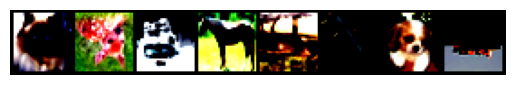

In [2]:
def imshow(img_tensor):
    """
    img_tensor: a batch of images in shape (B, C, H, W) or a single image in (C, H, W).
    """
    # If it's a batch of images (4D), make a grid first
    if len(img_tensor.shape) == 4:
        img_tensor = torchvision.utils.make_grid(img_tensor)
    # Unnormalize
    #img_tensor = unnormalize(img_tensor)
    # Convert to numpy
    npimg = img_tensor.numpy()
    # Transpose from (C, H, W) to (H, W, C)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(images[:8])

In [3]:
def param_to_bit(x : torch.Tensor) -> torch.Tensor:
    return torch.exp(x)

def bit_to_param(x : torch.Tensor) -> torch.Tensor:
    return torch.log(x)

def fake_float_truncate(x: torch.Tensor, e_bits: int, m_bits: int) -> torch.Tensor:
    """
    Approximate 'float' with e_bits exponent bits and m_bits mantissa bits.
    Simplified approach: unbiased exponent in integer range + truncated mantissa.
    """
    eps = 1e-45
    abs_x = x.abs().clamp(min=eps)
    sign = x.sign()
    
    # exponent
    e = torch.floor(torch.log2(abs_x))
    min_e = -(2**(e_bits)) + 1
    max_e =  (2**(e_bits)) - 1
    e_clamped = torch.clamp(e, min_e, max_e)
    
    # fraction in [1,2) if x >= eps
    frac = abs_x / (2.0 ** e_clamped)
    
    # truncate mantissa
    scale = 2.0 ** m_bits
    frac_trunc = torch.floor(frac * scale) / scale
    
    return sign * (2.0 ** e_clamped) * frac_trunc


class FakeFloatFunction(torch.autograd.Function):
    """
    Custom autograd for 'fake-float' exponent+mantissa truncation.
    """
    @staticmethod
    def forward(ctx, x, e_bits_param, m_bits_param):
        
        # save for backward
        ctx.save_for_backward(x, e_bits_param, m_bits_param)
        
        # Round e_bits, m_bits to nearest integer for the forward pass
        e_bits_int = int(torch.round(param_to_bit(e_bits_param)).clamp(min=0.0).item())
        m_bits_int = int(torch.round(param_to_bit(m_bits_param)).clamp(min=1.0).item())
        
        out = fake_float_truncate(x, e_bits_int, m_bits_int)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        x, e_bits_param, m_bits_param = ctx.saved_tensors
        
        e_bits_int = int(torch.round(param_to_bit(e_bits_param)).clamp(min=0.0).item())
        m_bits_int = int(torch.round(param_to_bit(m_bits_param)).clamp(min=1.0).item())
        
        # 1) Gradient wrt x: straight-through
        grad_x = grad_output.clone()
        
        # 2) Gradient wrt e_bits: approximate with central difference
        grad_e_bits = None
        if e_bits_param.requires_grad:
            delta = 0.01
            e_plus2_int  = int(torch.round(param_to_bit(e_bits_param + 2*delta)).clamp(min=0.0).item())
            e_plus_int   = int(torch.round(param_to_bit(e_bits_param +   delta)).clamp(min=0.0).item())
            e_minus_int  = int(torch.round(param_to_bit(e_bits_param -   delta)).clamp(min=0.0).item())
            e_minus2_int = int(torch.round(param_to_bit(e_bits_param - 2*delta)).clamp(min=0.0).item())
            
            f_plus2  = fake_float_truncate(x, e_plus2_int,  m_bits_int)
            f_plus   = fake_float_truncate(x, e_plus_int,   m_bits_int)
            f_minus  = fake_float_truncate(x, e_minus_int,  m_bits_int)
            f_minus2 = fake_float_truncate(x, e_minus2_int, m_bits_int)
            
            #diff_e = (f_plus - f_minus) * grad_output
            #grad_e_bits = diff_e.sum() / (2.0 * delta)
            
            diff_e = (-f_plus2 + 8*f_plus - 8*f_minus + f_minus2) * grad_output
            grad_e_bits = diff_e.sum() / (12.0 * delta)
        
        # 3) Gradient wrt m_bits: approximate with central difference
        grad_m_bits = None
        if m_bits_param.requires_grad:
            delta = 0.01
            m_plus2_int  = int(torch.round(param_to_bit(m_bits_param + 2*delta)).clamp(min=1.0).item())
            m_plus_int   = int(torch.round(param_to_bit(m_bits_param +   delta)).clamp(min=1.0).item())
            m_minus_int  = int(torch.round(param_to_bit(m_bits_param -   delta)).clamp(min=1.0).item())
            m_minus2_int = int(torch.round(param_to_bit(m_bits_param - 2*delta)).clamp(min=1.0).item())
            
            f_plus2  = fake_float_truncate(x, e_bits_int, m_plus2_int)
            f_plus   = fake_float_truncate(x, e_bits_int, m_plus_int)
            f_minus  = fake_float_truncate(x, e_bits_int, m_minus_int)
            f_minus2 = fake_float_truncate(x, e_bits_int, m_minus2_int)
            
            #diff_e = (f_plus - f_minus) * grad_output
            #grad_e_bits = diff_e.sum() / (2.0 * delta)
            
            diff_e = (-f_plus2 + 8*f_plus - 8*f_minus + f_minus2) * grad_output
            grad_m_bits = diff_e.sum() / (12.0 * delta)
        
        return grad_x, grad_e_bits, grad_m_bits


In [4]:
class SimpleCIFAR10Model(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_size[0], 32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * input_size[1]//4 * input_size[2]//4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc3(x)
        return x
    
class SimpleCIFAR10Model2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_size[0], 32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * input_size[1]//4 * input_size[2]//4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        #x = F.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        #x = F.dropout(x)
        x = self.fc3(x)
        return x

class SimpleQuantizedMLP(nn.Module):
    def __init__(self, e_bits=4.0, m_bits=4.0, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, num_classes)

        # Now we make them trainable:
        self.e_bits = nn.Parameter(torch.tensor(e_bits))
        self.m_bits = nn.Parameter(torch.tensor(m_bits))

    def forward(self, x):
        x = x.view(x.size(0), -1)

        w1 = FakeFloatFunction.apply(self.fc1.weight, self.e_bits, self.m_bits)
        b1 = FakeFloatFunction.apply(self.fc1.bias,   self.e_bits, self.m_bits)
        x  = F.relu(F.linear(x, w1, b1))

        w2 = FakeFloatFunction.apply(self.fc2.weight, self.e_bits, self.m_bits)
        b2 = FakeFloatFunction.apply(self.fc2.bias,   self.e_bits, self.m_bits)
        x  = F.linear(x, w2, b2)
        return x
    
    
class SimpleQuantizedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=input_size[0],  out_channels=32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * input_size[1]//4 * input_size[2]//4, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        learnInput = True
        learnInter = False
        inputsE = 8.0
        inputsM = 23.0
        learnConvBias = False
        learnConvWeights = True
        convE = 8.0
        convM = 23.0
        learnLineBias = True
        learnLineWeights = True
        lineE = 8.0
        lineM = 23.0
        
        self.i_e_bits_param = nn.ParameterList([
            nn.Parameter(bit_to_param(torch.tensor(inputsE)), requires_grad=learnInput),  # layer 0
            nn.Parameter(bit_to_param(torch.tensor(inputsE)), requires_grad=learnInter),  # layer 1
            nn.Parameter(bit_to_param(torch.tensor(inputsE)), requires_grad=learnInter),
            nn.Parameter(bit_to_param(torch.tensor(inputsE)), requires_grad=learnInter),
        ])
        
        self.i_m_bits_param = nn.ParameterList([
            nn.Parameter(bit_to_param(torch.tensor(inputsM)), requires_grad=learnInput),  # layer 0
            nn.Parameter(bit_to_param(torch.tensor(inputsM)), requires_grad=learnInter),  # layer 1
            nn.Parameter(bit_to_param(torch.tensor(inputsM)), requires_grad=learnInter),
            nn.Parameter(bit_to_param(torch.tensor(inputsM)), requires_grad=learnInter),
        ])
        
        self.w_e_bits_param = nn.ParameterList([
            nn.Parameter(bit_to_param(torch.tensor(convE)), requires_grad=learnConvWeights),  # layer 0
            nn.Parameter(bit_to_param(torch.tensor(convE)), requires_grad=learnConvWeights),  # layer 1
            nn.Parameter(bit_to_param(torch.tensor(lineE)), requires_grad=learnLineWeights),
            nn.Parameter(bit_to_param(torch.tensor(lineE)), requires_grad=learnLineWeights),
        ])
        
        self.w_m_bits_param = nn.ParameterList([
            nn.Parameter(bit_to_param(torch.tensor(convM)), requires_grad=learnConvWeights),  # layer 0
            nn.Parameter(bit_to_param(torch.tensor(convM)), requires_grad=learnConvWeights),  # layer 1
            nn.Parameter(bit_to_param(torch.tensor(lineM)), requires_grad=learnLineWeights),
            nn.Parameter(bit_to_param(torch.tensor(lineM)), requires_grad=learnLineWeights),
        ])
          
        self.b_e_bits_param = nn.ParameterList([
            nn.Parameter(bit_to_param(torch.tensor(convE)), requires_grad=learnConvBias),  # layer 0
            nn.Parameter(bit_to_param(torch.tensor(convE)), requires_grad=learnConvBias),  # layer 1
            nn.Parameter(bit_to_param(torch.tensor(lineE)), requires_grad=learnLineBias),
            nn.Parameter(bit_to_param(torch.tensor(lineE)), requires_grad=learnLineBias),
        ])
        
        self.b_m_bits_param = nn.ParameterList([
            nn.Parameter(bit_to_param(torch.tensor(convM)), requires_grad=learnConvBias),  # layer 0
            nn.Parameter(bit_to_param(torch.tensor(convM)), requires_grad=learnConvBias),  # layer 1
            nn.Parameter(bit_to_param(torch.tensor(lineM)), requires_grad=learnLineBias),
            nn.Parameter(bit_to_param(torch.tensor(lineM)), requires_grad=learnLineBias),
        ])
              
    def forward(self, x):
        
        x = FakeFloatFunction.apply(x, self.i_e_bits_param[0], self.i_m_bits_param[0])
        w1 = FakeFloatFunction.apply(self.conv1.weight, self.w_e_bits_param[0], self.w_m_bits_param[0])
        b1 = FakeFloatFunction.apply(self.conv1.bias,   self.b_e_bits_param[0], self.b_m_bits_param[0]) if self.conv1.bias is not None else None
        x = F.conv2d(x, w1, b1, stride=1, padding=1)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 32x32 -> 16x16
        
        #x = FakeFloatFunction.apply(x, self.i_e_bits_param[1], self.i_m_bits_param[1])
        w2 = FakeFloatFunction.apply(self.conv2.weight, self.w_e_bits_param[1], self.w_m_bits_param[1])
        b2 = FakeFloatFunction.apply(self.conv2.bias,   self.b_e_bits_param[1], self.b_m_bits_param[1]) if self.conv2.bias is not None else None
        x = F.conv2d(x, w2, b2, stride=1, padding=1)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16x16 -> 8x8
        
        x  = x.view(x.size(0), -1)
        
        #x = FakeFloatFunction.apply(x, self.i_e_bits_param[2], self.i_m_bits_param[2])
        w_fc1 = FakeFloatFunction.apply(self.fc1.weight, self.w_e_bits_param[2], self.w_m_bits_param[2])
        b_fc1 = FakeFloatFunction.apply(self.fc1.bias,   self.b_e_bits_param[2], self.b_m_bits_param[2])
        x = F.linear(x, w_fc1, b_fc1)
        #x = F.dropout(x)

        #x = FakeFloatFunction.apply(x, self.i_e_bits_param[3], self.i_m_bits_param[3])
        w_fc2 = FakeFloatFunction.apply(self.fc2.weight, self.w_e_bits_param[3], self.w_m_bits_param[3])
        b_fc2 = FakeFloatFunction.apply(self.fc2.bias,   self.b_e_bits_param[3], self.b_m_bits_param[3])
        x  = F.linear(x, w_fc2, b_fc2)

        return x
    
    def printBitWidths(self):
        for i, (eb, mb) in enumerate(zip(self.i_e_bits_param, self.i_m_bits_param)):
            print(f"Layer {i} input e_bits (float) = {param_to_bit(eb).item()},  m_bits (float) = {param_to_bit(mb).item()}")
        for i, (eb, mb) in enumerate(zip(self.w_e_bits_param, self.w_m_bits_param)):
            print(f"Layer {i} weight e_bits (float) = {param_to_bit(eb).item()},  m_bits (float) = {param_to_bit(mb).item()}")
        for i, (eb, mb) in enumerate(zip(self.b_e_bits_param, self.b_m_bits_param)):
            print(f"Layer {i} bias e_bits (float) = {param_to_bit(eb).item()},  m_bits (float) = {param_to_bit(mb).item()}")


In [5]:
def bitwidth_sum(model):
    """
    Computes a penalty term for the bitwidth parameters in 'model'.
    'lambda_bw' is the weight/scale for this regularization.
    """
    penalty = 0.0
    
    # If the model has multiple layers with e_bits and m_bits in a ParameterList:
    for eb, mb in zip(model.w_e_bits_param, model.w_m_bits_param):
        # Option A: Penalize the raw float value (the "continuous" version)
        penalty += eb + mb
        
        # Option B (alternative): Penalize the rounded integer version
        # penalty += torch.round(eb) + torch.round(mb)
    
    for eb, mb in zip(model.b_e_bits_param, model.b_m_bits_param):
        penalty += eb + mb

    for eb, mb in zip(model.i_e_bits_param, model.i_m_bits_param):
        penalty += eb + mb
                    
    return penalty


def bitwidth_squared(model):
    """
    Computes a penalty term for the bitwidth parameters in 'model'.
    'lambda_bw' is the weight/scale for this regularization.
    """
    penalty = 0.0
    
    # If the model has multiple layers with e_bits and m_bits in a ParameterList:
    for eb, mb in zip(model.w_e_bits_param, model.w_m_bits_param):
        # Option A: Penalize the raw float value (the "continuous" version)
        
        eb_ = eb - bit_to_param(torch.tensor(0.1))
        mb_ = mb - bit_to_param(torch.tensor(1.0))
        
        penalty += eb_*eb_ + mb_*mb_
        
        # Option B (alternative): Penalize the rounded integer version
        # penalty += torch.round(eb) + torch.round(mb)
    
    for eb, mb in zip(model.b_e_bits_param, model.b_m_bits_param):
        eb_ = eb - bit_to_param(torch.tensor(0.1))
        mb_ = mb - bit_to_param(torch.tensor(1.0))
        penalty += eb_*eb_ + mb_*mb_

    for eb, mb in zip(model.i_e_bits_param, model.i_m_bits_param):
        eb_ = eb - bit_to_param(torch.tensor(0.1))
        mb_ = mb - bit_to_param(torch.tensor(1.0))
        penalty += eb_*eb_ + mb_*mb_
                    
    return penalty

In [6]:
def train(model, device, train_loader, optimizer, epoch, lambda_bw=1.0e-3):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss_ce = F.cross_entropy(output, target)
        penalty_bw = bitwidth_squared(model) 
        #penalty_bw = bitwidth_sum(model) 
        loss = loss_ce + lambda_bw*penalty_bw
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        #if batch_idx % 200 == 0:
        #    print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
        #          f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
    
    train_loss /= len(train_loader)
    print(f"Train set: Average loss: {train_loss:.4f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy} ({100.0*accuracy:.2f}%)")
    return accuracy

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("using divice ", device)

# Create model
# model = SimpleQuantizedMLP(e_bits=4.0, m_bits=4.0, num_classes=len(classes)).to(device)
model = SimpleQuantizedCNN(num_classes=len(classes)).to(device)
#model = SimpleCIFAR10Model2(num_classes=len(classes)).to(device)

# Create optimizer (SGD or Adam)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_accuracy = 0.0
# Train for some epochs
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    accuracy = test(model, device, test_loader)
    if(accuracy > best_accuracy):
        best_accuracy = accuracy
        torch.save(model.state_dict(), "train_weights_and_quant_best_model.pth")
        
    model.printBitWidths()

using divice  cuda
Train set: Average loss: 2.0584
Test set: Average loss: 1.3179, Accuracy: 0.5279 (52.79%)
Layer 0 input e_bits (float) = 6.587833881378174,  m_bits (float) = 18.95368194580078
Layer 1 input e_bits (float) = 8.0,  m_bits (float) = 23.000001907348633
Layer 2 input e_bits (float) = 8.0,  m_bits (float) = 23.000001907348633
Layer 3 input e_bits (float) = 8.0,  m_bits (float) = 23.000001907348633
Layer 0 weight e_bits (float) = 6.587832927703857,  m_bits (float) = 18.953723907470703
Layer 1 weight e_bits (float) = 6.587832927703857,  m_bits (float) = 18.953678131103516
Layer 2 weight e_bits (float) = 6.587835788726807,  m_bits (float) = 18.95358657836914
Layer 3 weight e_bits (float) = 6.587831497192383,  m_bits (float) = 18.95359230041504
Layer 0 bias e_bits (float) = 8.0,  m_bits (float) = 23.000001907348633
Layer 1 bias e_bits (float) = 8.0,  m_bits (float) = 23.000001907348633
Layer 2 bias e_bits (float) = 6.587832927703857,  m_bits (float) = 18.95366859436035
Layer 3